In [1]:
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from scipy import stats
from sklearn import preprocessing
# SOURCES:
# https://stackoverflow.com/questions/53189494/apply-beautifulsoup-function-to-pandas-dataframe
# https://stackoverflow.com/questions/20297317/python-dataframe-pandas-drop-column-using-int
# Data Cleaning Notebook from Week 2 
# https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
# https://stackoverflow.com/questions/39885359/beautifulsoup-decompose
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

def has_tag(df, cols, tag):
    df_code = pd.DataFrame() 
    
    for c in cols:
        code = df[c].apply(lambda text: BeautifulSoup(text, 'html.parser').find_all(tag))
        col_name = c + '_HAS_CODE'
        
        code = (code.str.len() > 0).astype(int).rename(col_name).to_frame()
        df_code = pd.concat([df_code,code], axis=1)

    return df_code


def decompose_html(text, tag):   
    soup = BeautifulSoup(text, 'html.parser')
    code_tags = soup.findAll(tag)

    for code in code_tags:
        code.decompose()
    
    return str(soup)


def alter_col_text(df, cols, tag):   
    for c in cols:
        df[c] = df[c].apply(lambda text: decompose_html(text,tag))
        df[c] = df[c].apply(lambda text: BeautifulSoup(text, 'html.parser').text)
        df[c] = df[c].str.replace('\n',' ', regex=True)
    return df

df = pd.read_csv('data.csv',header=0)
values = {'QUESTION_BODY': '', 'ACCEPTED_ANSWER_BODY': ''}
df.fillna(value = values)

cols = ['QUESTION_TITLE',
        'QUESTION_BODY',
        'ACCEPTED_ANSWER_BODY',
        'QUESTION_FAVORITES',
        'QUESTION_SCORE',
        'QUESTION_VIEWS',
        'ANSWER_SCORE',
        'ANSWER_COMMENT_COUNT']

tag = 'code'

body_cols = cols[1:3]
df = pd.concat([df,has_tag(df, body_cols, tag)], axis=1)
df = alter_col_text(df, body_cols, 'code')

['QUESTION_FAVORITES', 'QUESTION_SCORE', 'QUESTION_VIEWS', 'ANSWER_SCORE', 'ANSWER_COMMENT_COUNT']


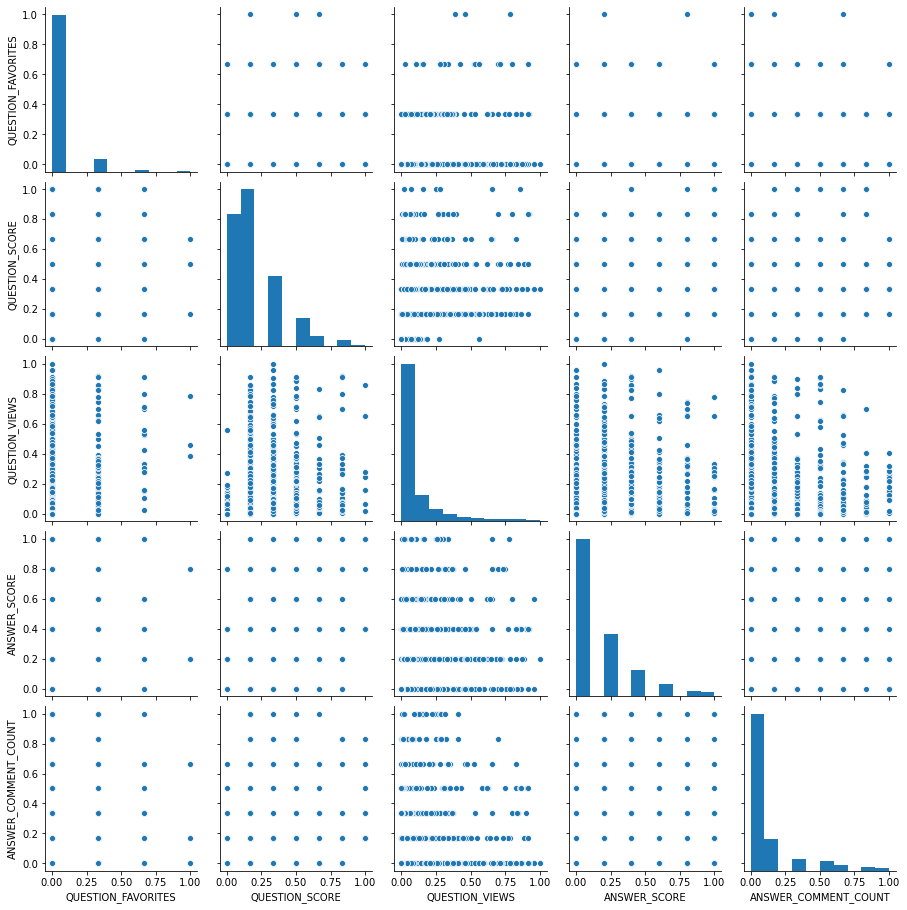

In [2]:
def fill_nan_columns(df, columns):
    for column in columns:
        df[column] = df[column].fillna(0)
    return df
   
    
def normalize_columns(df, cols):
    for c in cols:
        min_max_scaler = preprocessing.MinMaxScaler()
        c_scaled = min_max_scaler.fit_transform(df[c].to_frame().values)
        df[c] = pd.DataFrame(c_scaled)
    return df
        

def remove_outliers(df, columns):
    for column in columns:
        lower = df[column].quantile(0.05)
        upper = df[column].quantile(0.95)
        df = df[df[column] >= lower]
        df = df[df[column] <= upper]
    return df

quant_cols = cols[3:]
print(quant_cols)
df = fill_nan_columns(df, quant_cols)
df = remove_outliers(df, quant_cols)
df = normalize_columns(df, quant_cols)
df = fill_nan_columns(df, quant_cols)
sns.pairplot(df[quant_cols])
df.to_csv('out.csv')

In [30]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
#print(df.head())

# Regression on quantitative data
kf = KFold(n_splits=10, random_state=0, shuffle=True)
lasso = Lasso(alpha=0.005)
# Predict each of the following features using every other feature as its predictors
all_predictors = ['QUESTION_FAVORITES', 'QUESTION_VIEWS', 'QUESTION_SCORE', 'ANSWER_SCORE', 'ANSWER_COMMENT_COUNT', 'QUESTION_BODY_HAS_CODE', 'ACCEPTED_ANSWER_BODY_HAS_CODE']
for column in all_predictors:
    train_score_sum = 0
    test_score_sum = 0
    coeff_sums = {}
    count = 0
    feature = column
    predictors = [x for x in all_predictors if x != column]
    for predictor in predictors:
        coeff_sums[predictor] = 0.0
    print('feature: ', feature)
    for train_index, test_index in kf.split(df):
        x_train = df[predictors].iloc[train_index]
        y_train = df[feature].iloc[train_index]
        x_test = df[predictors].iloc[test_index]
        y_test = df[feature].iloc[test_index]

        lasso.fit(x_train, y_train)

        train_score_sum += lasso.score(x_train, y_train)
        test_score_sum += lasso.score(x_test, y_test)
        count += 1
        
        i = 0
        for predictor in predictors:
            coeff_sums[predictor] += lasso.coef_[i]
            i += 1

        #print('coefficients: ', lasso.coef_)
    
    print('average train score for ', feature, ': ', train_score_sum/count)
    print('average test score for ', feature, ': ', test_score_sum/count)
    print('coefficients: ')
    for predictor in predictors:
        print(predictor, ': ', coeff_sums[predictor]/count)
    print()


feature:  QUESTION_FAVORITES
average train score for  QUESTION_FAVORITES :  0.07277298576147714
average test score for  QUESTION_FAVORITES :  0.05898036581019074
coefficients: 
QUESTION_VIEWS :  0.0058131752427822096
QUESTION_SCORE :  0.04903214119861428
ANSWER_SCORE :  0.027307034565341903
ANSWER_COMMENT_COUNT :  0.0
QUESTION_BODY_HAS_CODE :  0.0
ACCEPTED_ANSWER_BODY_HAS_CODE :  0.0

feature:  QUESTION_VIEWS
average train score for  QUESTION_VIEWS :  0.15766985339716438
average test score for  QUESTION_VIEWS :  0.14222748248731615
coefficients: 
QUESTION_FAVORITES :  0.0
QUESTION_SCORE :  0.2068235553438214
ANSWER_SCORE :  0.04618381974155592
ANSWER_COMMENT_COUNT :  0.0
QUESTION_BODY_HAS_CODE :  0.0
ACCEPTED_ANSWER_BODY_HAS_CODE :  0.0

feature:  QUESTION_SCORE
average train score for  QUESTION_SCORE :  0.32988949655795763
average test score for  QUESTION_SCORE :  0.3189612803293257
coefficients: 
QUESTION_FAVORITES :  0.0
QUESTION_VIEWS :  0.16134846628899183
ANSWER_SCORE :  0.323653

In [11]:
print(df.columns)

Index(['QUESTION_TITLE', 'QUESTION_BODY', 'ACCEPTED_ANSWER_BODY',
       'QUESTION_FAVORITES', 'QUESTION_SCORE', 'QUESTION_VIEWS',
       'ANSWER_SCORE', 'ANSWER_COMMENT_COUNT', 'QUESTION_BODY_HAS_CODE',
       'ACCEPTED_ANSWER_BODY_HAS_CODE'],
      dtype='object')
